In [1]:
import sys
sys.path.append('../src/')

from decision_engine import MinimalSupplierSelectionModel, SupplierSelectionModel
from utils import generate_supplier_selector_variables, compute_reduced_price

---

# Decision Engine

### Aims

- Detail an example where real quantifiable value has been delivered to a customer
- Breakdown the supplier selection problem to its simplest form and then gently build up to a real problem in a way that promotes understanding. 
- Understand the general structure of the supplier selection problem (combinatorial optimisation problem)
- After studying this notebook, you should be able to identify structurally similar problems when talking to potential clients

### Who should read this notebook?

- Anyone
- There is no maths: only a problem statement and the solution

---

# Typical problem statement

- Rolls-Royce need to procure approximately 1000 unique forged metal parts for the Trent XWB engine.
- There are 30 suppliers globally that have the skills and equipment to manufacture the required parts.
- Rolls-Royce provide all 30 suppliers with the information required to price and submit a bid to manufacture any unique part.
- Rolls-Royce receive the bids and must then decide who is awarded the manufacturing contract for every unique part

### Constraints

- At first this might appear to be trivial (select the cheapest bid for every part), however there are a number of constraints that must be considered
    - There is a limit on the number of unique parts that a supplier can manufacture
    - Manufacturers based in certain countries (e.g. China) are limited to manufacturing a percentage of the total required units of a unique part
    
### Combinatorial optimisation

- The problem is no longer trivial and is an example of a combinatorial optimisation problem 
- A combinatorial optimisation problem is the act of trying to find out the value (combination) of variables that optimises an index (value) from among many options under various constraints.
- The problem can be solved using constraint programming (CP) techniques

---

# Minimal problem

The supplier selection problem reduced to its most basic form

### Demand

A buyer is tasked with sourcing four parts for the manufacturing of a jet
engine. The demand for each part is defined by the below table.

| Part 1 | Part 2 | Part 3 | Part 4 |
| ------ | ------ | ------ | ------ |
| 300 | 20 | 150 | 80 |

### Price

There are two suppliers from which the buyer can source the required parts. The price quoted by each supplier for every part is detailed in the following table.

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | £60k | £605k | £9.5k | £75k |
| 2 | £50k | £615k | £9.8k | £60k |

### Manufacturing capacity

Each supplier has constraints on manufacturing - i.e. they only have the capacity to manufacture $x$ unique parts. The manufacturing capacity of both suppliers is specified below.

| Supplier | Unique parts limit | 
| -------- | ----------- |
| 1 | 2 |
| 2 | 3 |

### Objective and constraints

The **objective** is to minimise the total cost of procuring parts subject to the following constraints:

- Constraint 1 - a supplier cannot be assigned more unique parts than that defined by their manufacturing capacity
- Constraint 2 - the total number of units ordered (assigned to suppliers for manufacturing) must be equal to demand

## Solution

The buyer must procure parts from suppliers so that the total cost is minimised. The optimal solution (i.e. the solution that minimises cost) is detailed in the following table.

In [2]:
price = [[60E3, 605E3, 9.5E3, 75E3],
         [50E3, 615E3, 9.8E3, 60E3]]

demand = [300, 20, 150, 80]

capacity = [2, 3]

supplier_selection_min_a = MinimalSupplierSelectionModel(price, demand, capacity)

In [3]:
supplier_selection_min_a.minimise_cost()


Optimal solution found: cost - £33,325,000.00

Supplier 1
----------
Part 1 units: 0
Part 2 units: 20
Part 3 units: 150
Part 4 units: 0

Supplier 2
----------
Part 1 units: 300
Part 2 units: 0
Part 3 units: 0
Part 4 units: 80


---

# Additional constraints

## Maximum share

The buyer might have to consider an additional constraint on the maximum share of a unique part that can be assigned to a supplier. For example, manufacturers in China can only be assigned 30\% of the volume for certain parts.

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | 100% | 100% | 30% | 100% |
| 2 | 80% | 100% |70% | 100% |

## Solution

Solving the same problem but with constraints on the maximum share, the cost rises from **£33,325,000** to **£36,556,200**.

In [4]:
price = [[60E3, 605E3, 9.5E3, 75E3],
         [50E3, 615E3, 9.8E3, 60E3]]

demand = [300, 20, 150, 80]

capacity = [2, 3]

share = [[100, 100, 30, 100],
         [80, 100, 70, 100]]

supplier_selection_min_b = MinimalSupplierSelectionModel(price, demand, capacity, share)

In [5]:
supplier_selection_min_b.minimise_cost()


Optimal solution found: cost - £36,556,200.00

Supplier 1
----------
Part 1 units: 300
Part 2 units: 0
Part 3 units: 46
Part 4 units: 0

Supplier 2
----------
Part 1 units: 0
Part 2 units: 20
Part 3 units: 104
Part 4 units: 80


### Units (volume) - without maximum share constraint

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | 0 | 20 | 150 | 0 |
| 2 | 300 | 0 | 0 | 80 |

### Units (volume) - with maximum share constraint

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | 300 | 0 | 46 | 0 |
| 2 | 0 | 20 | 104 | 80 |

### Computational complexity

Using a naive brute force method to solve this problem is extremely computationally expensive. Every cell in the above table can take a value from 0 to 300. Using a naive brute force method, we would have to compute $300^8$ possible combinations and then select the best solution. To put this in perspective, $300^8$ is $\approx 6.6\times10^{19}$ which is approaching the number of grains of sand on all the worlds beaches. Clearly this problem is computationally intractable if we employ a brute force method. Fortunately, by accounting for the constraints, the potential solution space can be significantly reduced and the problem becomes computationally feasible. All of this complexity is handled by Google OR-Tools.

---

# Going beyond the minimal problem

## Adding a time dimension

The price of parts is a function of time and changes year to year. For example, the price of parts will increase over time due to inflationary effects. Conversely the price might decrease due to learning effects. This is where the cost of production per unit decreases over time as suppliers become more familiar with the production process, hence leading to improvements in their efficiency level. The buyer might wish to switch the supplier of a part as time progresses but there will also be an associated transfer cost.

## Constraints

There are a number of additional constraints that we must consider:

- Global transfer limit - in a given year the total number of transfers must be equal to or less than the global transfer limit. This help to maintain the robustness of the supply chain.
- Supplier transer limit - in a given year the total number of transfers that a supplier can accept must be less than the supplier transfer limit. This helps to maintain the robustness of the supply chain.
- Contractual requirements - for example, a supplier must provide a specific quantity of a part in a given year
- Minimum units (volume) - a supplier will only accept a contract to manufacture a part if the number of units exceeds a minimum threshold

### Price

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | [£60k, £62k, £64k] | [£605k, £610k, £605k] | [£9.5k, £9.6k, £9.7k] | [£75k, £75k, £75k] |
| 2 | [£50k, £55k, £60k] | [£615k, £610k, £605k] | [£9.8k, £9.7k, £9.6k] | [£60k, £70k, £80k] |


### Transfer costs

One off cost associated with retooling a factory so that a new part can be produced - not related to volume (note: not implemented in this example)

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | [£0, £0, £0] | [£1000k, £1100k, £1200k] | [£0, 0, 0] | [£700k, £750k, £800k] |
| 2 | [£600k, £650k, £700k] | [£0, 0, 0] | [£0, 0, 0] | [£800k, £900k, £1000k] |


### Transfer limits

There is a limit on the number of transfers that a supplier can make due to the disruption incurred. There is also a global limit on the number of transfers to help maintain the resilience of the supply chain.

$$\textrm{global transfer limit per year} = 2$$

| Supplier | Transfer limit | 
| -------- | ----------- |
| 1 | 2 |
| 2 | 1 |

### Demand

| Part 1 | Part 2 | Part 3 | Part 4 |
| ------ | ------ | ------ | ------ |
| [300, 310, 320] | [20, 30, 40] | [150, 145, 130] | [80, 80, 80] |

### Manufacturing capacity

| Supplier | Parts limit | 
| -------- | ----------- |
| 1 | [2, 3, 3] |
| 2 | [3, 2, 2] |

### Maximum Share

The maximum share of a part that can be assigned to a supplier - e.g. manufactures based in China can only be assigned 30% of volume for an individual part

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | 100 | 100 | 30 | 100 |
| 2 | 80 | 100 | 70 | 100 |


In [6]:
price = [[[60E3, 62E3, 64E3], [605E3, 610E3, 615E3], [9.5E3, 9.6E3, 9.7E3], [75E3, 75E3, 75E3]],
         [[50E3, 55E3, 60E3], [615E3, 610E3, 605E3], [9.8E3, 9.7E3, 9.6E3], [60E3, 70E3, 80E3]]]

demand = [[300, 310, 320], [20, 30, 40], [150, 145, 130], [80, 80, 80]]

capacity = [[4, 4, 4], [3, 3, 3]]

share = [[100, 100, 30, 100],
         [80, 100, 70, 100]]

supplier_transfer_limit = [1, 2]

supplier_selection_time = SupplierSelectionModel(price, 
                                                 demand, 
                                                 capacity=capacity, 
                                                 supplier_transfer_limit=supplier_transfer_limit, 
                                                 share=share)

Execution time: 0.00187 seconds


In [7]:
supplier_selection_time.minimise_cost()


Optimal solution found: cost - £127,597,100.00
Execution time: 0.01880 seconds


In [8]:
supplier_selection_time.print_solution(volume=True)



Part  1              1         2         3
-------

Supplier  1:        58        59        61

Supplier  2:       242       251       259


Part  2              1         2         3
-------

Supplier  1:        20        30         0

Supplier  2:         0         0        40


Part  3              1         2         3
-------

Supplier  1:        46        44        38

Supplier  2:       104       101        92


Part  4              1         2         3
-------

Supplier  1:         0         0        80

Supplier  2:        80        80         0


### Contractual requirements

Suppose that there is a contractual requirement that Supplier 1 must provide 70 units of Part 3 in year 2. How does this impact the minimal cost?

The minimal costs rises from **£127,597,100** to **£128,347,100**

In [9]:
supplier_selection_contract = SupplierSelectionModel(price, 
                                                     demand, 
                                                     capacity=capacity, 
                                                     supplier_transfer_limit=supplier_transfer_limit, 
                                                     share=share)

supplier_selection_contract.set_volume_constraint(1, 3, 2, 70) 

Execution time: 0.00185 seconds


In [10]:
supplier_selection_contract.minimise_cost()


Optimal solution found: cost - £128,347,100.00
Execution time: 0.01443 seconds


In [11]:
supplier_selection_contract.print_solution(volume=True)



Part  1              1         2         3
-------

Supplier  1:        58        59        61

Supplier  2:       242       251       259


Part  2              1         2         3
-------

Supplier  1:        20        30        40

Supplier  2:         0         0         0


Part  3              1         2         3
-------

Supplier  1:        46        44        38

Supplier  2:       104       101        92


Part  4              1         2         3
-------

Supplier  1:         0         0        10

Supplier  2:        80        80        70


### Minimum units (volume)

Minimum units (volume) - a supplier will only accept a contract to manufacture a part if the number of units awarded exceeds a minimum threshold

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | [100, 100, 100] | [5, 5, 5] | [20, 25, 30] | [15, 15, 15] |
| 2 | [100, 100, 100] | [5, 5, 5] | [20, 25, 30] | [15, 15, 15] |

If we enforced the minimum units constraint the minimal costs rises from **£127,597,100** to **£128,460,100**

In [12]:
min_units = [[[100, 100, 100], [5, 5, 5], [20, 25, 30], [15, 15, 15]],
             [[100, 100, 100], [5, 5, 5], [20, 25, 30], [15, 15, 15]]]

supplier_selection_min_units = SupplierSelectionModel(price, 
                                                      demand, 
                                                      capacity=capacity, 
                                                      supplier_transfer_limit=supplier_transfer_limit, 
                                                      share=share,
                                                      minimum_units=min_units)

Execution time: 0.00194 seconds


In [13]:
supplier_selection_min_units.minimise_cost()


Optimal solution found: cost - £128,460,100.00
Execution time: 0.01423 seconds


In [14]:
supplier_selection_min_units.print_solution(volume=True)



Part  1              1         2         3
-------

Supplier  1:       100       100       100

Supplier  2:       200       210       220


Part  2              1         2         3
-------

Supplier  1:        20        30         0

Supplier  2:         0         0        40


Part  3              1         2         3
-------

Supplier  1:        46        44        38

Supplier  2:       104       101        92


Part  4              1         2         3
-------

Supplier  1:         0         0        80

Supplier  2:        80        80         0


### Trust

Rolls-Royce buyers assign a trust value to every supplier and part. Trust is an uncertain metric that represents confidence in a supplier and is based on the historical performance of a supplier. In the simplest case, trust is a boolean variable: `True` - Rolls-Royce trust Supplier $x$ to manufacture Part $y$, `False` - Rolls-Royce do not trust Supplier $x$ to manufacture Part $y$.

| Supplier | Part 1 | Part 2 | Part 3 | Part 4 |
| -------- | ------ | ------ | ------ | ------ |
| 1 | True | False | True | True |
| 2 | True | True | True | False |

If we enforced the trust constraint the minimal costs rises from **£128,460,100** to **£130,260,100**

In [15]:
trust = [[True, False, True, True],
         [True, True, True, False]]

supplier_selection_trust = SupplierSelectionModel(price, 
                                                  demand, 
                                                  capacity=capacity, 
                                                  supplier_transfer_limit=supplier_transfer_limit, 
                                                  share=share,
                                                  minimum_units=min_units,
                                                  trust=trust)

Execution time: 0.00315 seconds


In [16]:
supplier_selection_trust.minimise_cost()


Optimal solution found: cost - £130,260,100.00
Execution time: 0.00352 seconds


In [17]:
supplier_selection_trust.print_solution(volume=True)



Part  1              1         2         3
-------

Supplier  1:       100       100       100

Supplier  2:       200       210       220


Part  2              1         2         3
-------

Supplier  1:         0         0         0

Supplier  2:        20        30        40


Part  3              1         2         3
-------

Supplier  1:        46        44        38

Supplier  2:       104       101        92


Part  4              1         2         3
-------

Supplier  1:        80        80        80

Supplier  2:         0         0         0


## Solving a larger problem - with and without global transfer limit

In [18]:
(price, demand, capacity, share, 
 supplier_transfer_limit, min_units, 
 trust) = generate_supplier_selector_variables(n_suppliers=5, 
                                               n_parts=25,
                                               n_years=10,
                                               print_data=False,
                                               seed_value=2);

supplier_selection = SupplierSelectionModel(price,
                                            demand,
                                            capacity=capacity,
                                            supplier_transfer_limit=supplier_transfer_limit,
                                            share=share,
                                            minimum_units=min_units,
                                            trust=trust)

supplier_selection_gtl = SupplierSelectionModel(price, 
                                                demand, 
                                                capacity=capacity, 
                                                supplier_transfer_limit=supplier_transfer_limit, 
                                                share=share,
                                                global_transfer_limit=1,
                                                minimum_units=min_units,
                                                trust=trust)

Execution time: 0.13362 seconds
Execution time: 0.13483 seconds


In [19]:
supplier_selection.minimise_cost()
supplier_selection_gtl.minimise_cost()


Optimal solution found: cost - £2,149,492,118.00
Execution time: 1.64745 seconds

Optimal solution found: cost - £2,149,881,615.00
Execution time: 2.56876 seconds


In [20]:
supplier_selection.print_solution(volume=True)



Part  1              1         2         3         4         5         6         7         8         9        10
-------

Supplier  1:         0         0         0         0         0         0         0         0         0         0

Supplier  2:        73         0       158       154         0         0         0         0         0         0

Supplier  3:       113         0         0         0         0         0         0         0         0         0

Supplier  4:         0         0         0         0         0         0         0         0        88        93

Supplier  5:         0       166         0         0       157       153       162       150        57        60


Part  2              1         2         3         4         5         6         7         8         9        10
-------

Supplier  1:         0         0         0         0         0         0         0         0         0         0

Supplier  2:       117       130         0       132        50       

In [21]:
supplier_selection_gtl.print_solution(volume=True)



Part  1              1         2         3         4         5         6         7         8         9        10
-------

Supplier  1:         0         0         0         0         0         0         0         0         0         0

Supplier  2:        54        17       142       139         0         0         0         0         0         0

Supplier  3:       113         0         0         0         0         0         0         0         0         0

Supplier  4:         0         0         0         0         0         0         0         0        88        93

Supplier  5:        19       149        16        15       157       153       162       150        57        60


Part  2              1         2         3         4         5         6         7         8         9        10
-------

Supplier  1:         0         0         0         0         0         0         0         0         0         0

Supplier  2:        93       104        14       106        37       

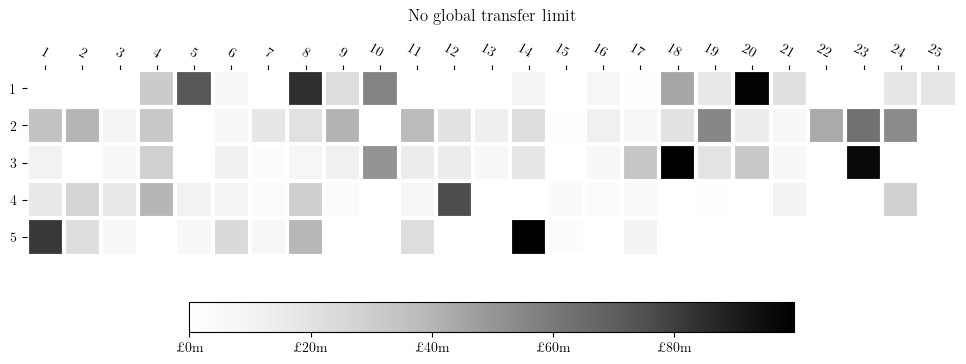

In [22]:
supplier_selection.plot_heatmap(name="No global transfer limit")

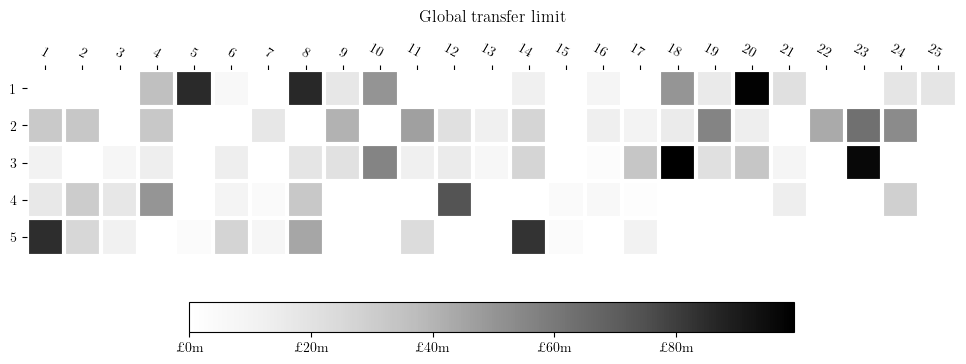

In [23]:
supplier_selection_gtl.plot_heatmap(name="Global transfer limit")

---

# Scenario generation - asking business questions

What would happen if Supplier 3 reduced all their prices by 10%? How much additional work would Supplier 3 win?

In [24]:
reduced_price = compute_reduced_price(price, 2, 0.1)
supplier_selection_reduced_prices = SupplierSelectionModel(reduced_price,
                                                           demand,
                                                           capacity=capacity,
                                                           supplier_transfer_limit=supplier_transfer_limit,
                                                           share=share,
                                                           minimum_units=min_units,
                                                           trust=trust)
supplier_selection_reduced_prices.minimise_cost()

Execution time: 0.14139 seconds

Optimal solution found: cost - £2,038,809,366.00
Execution time: 1.41316 seconds


## Base scenario

Supplier 3 wins work with a value of **£469,240,000**

In [25]:
supplier_selection.print_work_value()


Supplier  1: £      507.74 m

Supplier  2: £      567.10 m

Supplier  3: £      469.24 m

Supplier  4: £      286.79 m

Supplier  5: £      318.62 m


In [26]:
supplier_selection.print_work_value_detailed()


Supplier  1: 
------------

Part  1: £        0.00 m
Part  2: £        0.00 m
Part  3: £        0.00 m
Part  4: £       30.82 m
Part  5: £       72.35 m
Part  6: £        6.64 m
Part  7: £        0.00 m
Part  8: £       84.41 m
Part  9: £       22.35 m
Part 10: £       56.05 m
Part 11: £        0.00 m
Part 12: £        0.00 m
Part 13: £        0.00 m
Part 14: £        8.70 m
Part 15: £        0.00 m
Part 16: £        7.65 m
Part 17: £        1.27 m
Part 18: £       44.58 m
Part 19: £       16.71 m
Part 20: £       98.34 m
Part 21: £       21.49 m
Part 22: £        0.00 m
Part 23: £        0.00 m
Part 24: £       18.35 m
Part 25: £       18.03 m

Supplier  2: 
------------

Part  1: £       34.77 m
Part  2: £       40.04 m
Part  3: £        8.42 m
Part  4: £       32.11 m
Part  5: £        0.00 m
Part  6: £        5.36 m
Part  7: £       17.39 m
Part  8: £       20.32 m
Part  9: £       40.45 m
Part 10: £        0.00 m
Part 11: £       37.83 m
Part 12: £       20.20 m
Part 13: £       

## Scenario A - Supplier 3 reduces all quoted prices by 10%

Supplier 3 wins work with a value of **£1,042,900,000**

In [27]:
supplier_selection_reduced_prices.print_work_value()


Supplier  1: £      295.50 m

Supplier  2: £      345.47 m

Supplier  3: £    1,042.90 m

Supplier  4: £      177.53 m

Supplier  5: £      177.42 m


In [28]:
supplier_selection_reduced_prices.print_work_value_detailed()


Supplier  1: 
------------

Part  1: £        0.00 m
Part  2: £        0.00 m
Part  3: £        0.00 m
Part  4: £        0.00 m
Part  5: £       63.10 m
Part  6: £        6.55 m
Part  7: £        0.24 m
Part  8: £       63.05 m
Part  9: £        6.60 m
Part 10: £        0.00 m
Part 11: £        0.00 m
Part 12: £        0.00 m
Part 13: £        0.00 m
Part 14: £        8.70 m
Part 15: £        0.00 m
Part 16: £        3.73 m
Part 17: £        1.75 m
Part 18: £       38.23 m
Part 19: £       13.89 m
Part 20: £       45.38 m
Part 21: £       18.24 m
Part 22: £        0.00 m
Part 23: £        0.00 m
Part 24: £        7.99 m
Part 25: £       18.03 m

Supplier  2: 
------------

Part  1: £       17.71 m
Part  2: £        0.00 m
Part  3: £        6.49 m
Part  4: £        0.00 m
Part  5: £        0.00 m
Part  6: £        3.49 m
Part  7: £        6.47 m
Part  8: £       11.61 m
Part  9: £       23.93 m
Part 10: £        0.00 m
Part 11: £        0.00 m
Part 12: £       20.38 m
Part 13: £       

## Scenario comparison

Work migration from Base Scenario to Scenario A

$$\textrm{diff} = \textrm{Scenario A} - \textrm{Base Scenario}$$

In [29]:
supplier_selection_reduced_prices - supplier_selection


Supplier  1: 
------------

Part  1: £        0.00 m
Part  2: £        0.00 m
Part  3: £        0.00 m
Part  4: £      -30.82 m
Part  5: £       -9.25 m
Part  6: £       -0.09 m
Part  7: £        0.24 m
Part  8: £      -21.36 m
Part  9: £      -15.75 m
Part 10: £      -56.05 m
Part 11: £        0.00 m
Part 12: £        0.00 m
Part 13: £        0.00 m
Part 14: £        0.00 m
Part 15: £        0.00 m
Part 16: £       -3.92 m
Part 17: £        0.48 m
Part 18: £       -6.35 m
Part 19: £       -2.82 m
Part 20: £      -52.96 m
Part 21: £       -3.25 m
Part 22: £        0.00 m
Part 23: £        0.00 m
Part 24: £      -10.35 m
Part 25: £        0.00 m

Supplier  2: 
------------

Part  1: £      -17.06 m
Part  2: £      -40.04 m
Part  3: £       -1.93 m
Part  4: £      -32.11 m
Part  5: £        0.00 m
Part  6: £       -1.87 m
Part  7: £      -10.93 m
Part  8: £       -8.71 m
Part  9: £      -16.52 m
Part 10: £        0.00 m
Part 11: £      -37.83 m
Part 12: £        0.18 m
Part 13: £       

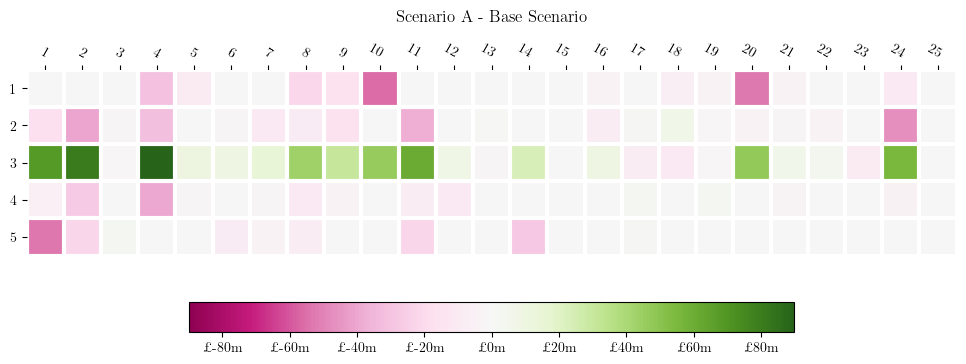

In [35]:
supplier_selection_reduced_prices.heatmap_difference(supplier_selection, name="Scenario A - Base Scenario")

## Scenario B - what if we trust all suppliers?

By how much does the total cost change if we trust all suppliers?

In [31]:
supplier_selection_all_trusted = SupplierSelectionModel(reduced_price, 
                                                        demand, 
                                                        capacity=capacity, 
                                                        supplier_transfer_limit=supplier_transfer_limit, 
                                                        share=share,
                                                        global_transfer_limit=1,
                                                        minimum_units=min_units)

supplier_selection_all_trusted.minimise_cost()

Execution time: 0.12291 seconds

Optimal solution found: cost - £2,042,097,918.00
Execution time: 2.20687 seconds


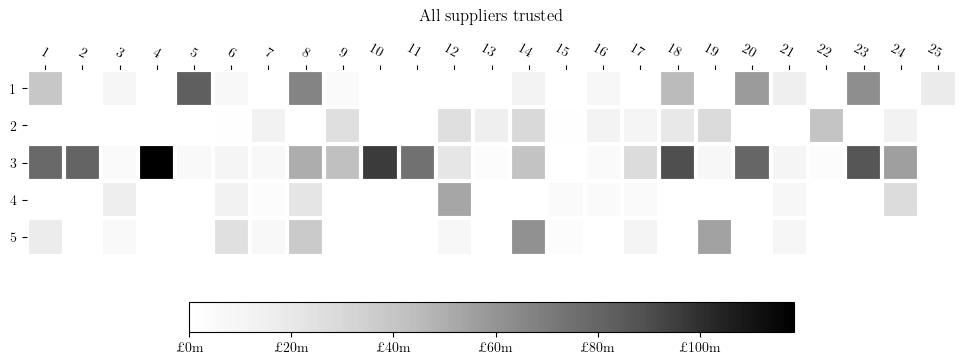

In [32]:
supplier_selection_all_trusted.plot_heatmap(name="All suppliers trusted")

## Scenario C - no constraints

By how much does the total cost change if there are no constraints?

In [33]:
supplier_selection_no_constraints = SupplierSelectionModel(reduced_price, 
                                                           demand)

supplier_selection_no_constraints.minimise_cost()

Execution time: 0.05073 seconds

Optimal solution found: cost - £1,946,939,082.00
Execution time: 0.03991 seconds


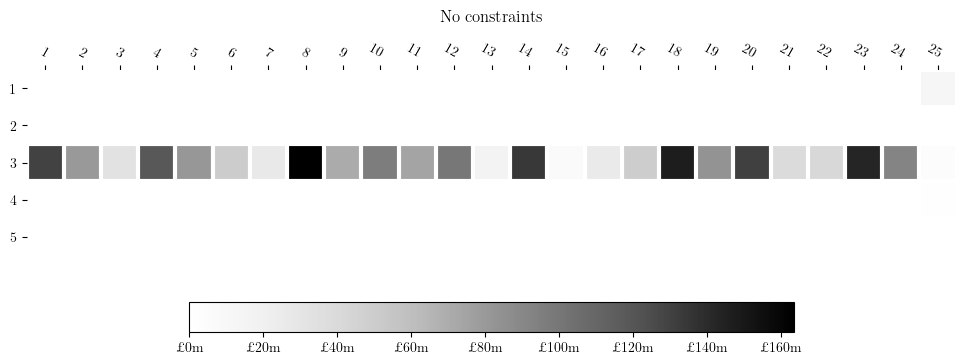

In [34]:
supplier_selection_no_constraints.plot_heatmap(name="No constraints")

---

# Additional factors to consider

In all the above examples, the objective is to minimise cost. However, many other factors must be considered when awarding manufacturing contracts. 

- Trust (an uncertain metric that represents confidence in a supplier)
- $\textrm{CO}_2$ emissions
- Transport distance
- ESG